In [4]:
import os
import cv2

import torch
import numpy as np

from skimage import draw
from pathlib import Path

import pytorch_lightning as pl
import matplotlib.pyplot as plt
from omegaconf import OmegaConf, DictConfig
from collections.abc import Callable
from typing import Tuple, Dict, Optional



from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from utils import setup_data_module, setup_model_module, remove_prefix

In [5]:
def setup(cfg):

    cfg.loader.batch_size = 1

    if 'split' not in cfg:
        cfg.split = 'val'

    if 'shuffle' not in cfg:
        cfg.shuffle = False


def setup_config(cfg: DictConfig, override: Optional[Callable] = None):
    OmegaConf.set_struct(cfg, False)

    if override is not None:
        override(cfg)
    OmegaConf.resolve(cfg)
    OmegaConf.set_struct(cfg, True)


def resume_training(uuid):
    save_dir = Path('/usr/src/CV_For_Autonomous_Driving/logs/')
    checkpoints = list(save_dir.glob(f'**/{uuid}/checkpoints/*.ckpt'))

    print(f'Searching {save_dir}.')

    if not checkpoints:
        return None

    print(f'Found {checkpoints[-1]}.')

    return checkpoints[-1]

In [6]:

# *  config setup  * #
CONFIG_PATH = '/usr/src/CV_For_Autonomous_Driving/config'

with initialize_config_dir(config_dir=CONFIG_PATH):
    cfg = compose(config_name='default_config.yaml',)
    
setup_config(cfg, setup)
pl.seed_everything(cfg.experiment.seed, workers=True)


data = setup_data_module(cfg)
loader = data.get_split(cfg.split, shuffle=cfg.shuffle)

print(f'{cfg.split}: {len(loader)} total samples')


# *  load trained network  * #
model_module = setup_model_module(cfg)

uuid = '0103_070026'
ckpt_path = resume_training(uuid)
print(ckpt_path)
ckpt = torch.load(ckpt_path)
state_dict = remove_prefix(ckpt['state_dict'], 'fullmodel')

model_module.fullmodel.load_state_dict(state_dict)
model_module.to('cuda')

print(f'finish load trained {cfg.experiment.uuid} network ')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  after removing the cwd from sys.path.
Global seed set to 2022


Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 41.095 seconds.
Reverse indexing ...
Done reverse indexing in 13.3 seconds.
val: 6019 total samples
Loaded pretrained weights for efficientnet-b4
Searching /usr/src/CV_For_Autonomous_Driving/logs.
Found /usr/src/CV_For_Autonomous_Driving/logs/CV_For_Autonomous_Driving/0103_070026/checkpoints/model-v1.ckpt.
/usr/src/CV_For_Autonomous_Driving/logs/CV_For_Autonomous_Driving/0103_070026/checkpoints/model-v1.ckpt


/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (IoUMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


finish load trained 0104_011245 network 


In [7]:
batch = next(iter(loader))
for k, v in batch.items():
    batch[k] = v.to('cuda')

out = model_module.vis_step(batch, 0)

In [12]:
pred = out['pred']['bev']       # 1, 4, 256, 256

_, c, h, w = pred.shape
bool = pred.sigmoid() > 0.5
bool = bool.squeeze(0).cpu().numpy()

vis = []
for i in range(c-1):
    bev = np.full((h, w), 0, dtype='uint8')
    bev[bool[i]] = 1
    vis.append(bev)

total = np.hstack(vis)
total = cv2.resize(total, (768*2, 512))

In [13]:
total.shape

(512, 1536)

In [16]:
plt.imsave('output.png', total)

(-0.5, 1535.5, 511.5, -0.5)

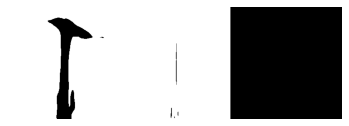

In [14]:
plt.imshow(total)
plt.axis('off')